In [1]:
# notebook to get started running ignition delays
# not going to use pyteck because it's too bulky for me to run 5000 and do global analysis

In [2]:
import cantera as ct

import matplotlib.pyplot as plt

In [72]:
# Load the model
model_cti = '/work/westgroup/harris.se/autoscience/autoscience/butane/chem_annotated.cti'
gas = ct.Solution(model_cti)


# load aramco
aramco_cti = '/work/westgroup/harris.se/autoscience/aramco/AramcoMech3.0.MECH.cti'
aramco_gas = ct.Solution(aramco_cti)

In [87]:
# run Aramco for reference
# set initial conditions
# aramco_gas.TPX = 1077, ct.one_atm * 10, 'AR: 0.7821, C4H10: 0.00962, O2: 0.2083'
aramco_gas.TPX = 1220, 1.02 * ct.one_atm, 'AR: 0.7821, C4H10: 0.00962, O2: 0.2083'
end_time = 1.0  # time in seconds


# Create non-interacting ``Reservoir`` on other side of ``Wall``
aramco_env = ct.Reservoir(ct.Solution('air.xml'))

aramco_reactor = ct.IdealGasReactor(aramco_gas)

# Rapid compression machine modeled by constant UV
aramco_wall = ct.Wall(aramco_reactor, env, A=1.0, velocity=0)


aramco_reactor_net = ct.ReactorNet([aramco_reactor])




times = [0]
T = [aramco_reactor.T]
P = [aramco_reactor.thermo.P]
X = [aramco_reactor.thermo.X]  # mol fractions
while aramco_reactor_net.time < end_time:
    aramco_reactor_net.step()
    
    times.append(aramco_reactor_net.time)
    T.append(aramco_reactor.T)
    P.append(aramco_reactor.thermo.P)
    X.append(aramco_reactor.thermo.X)
    
    
 

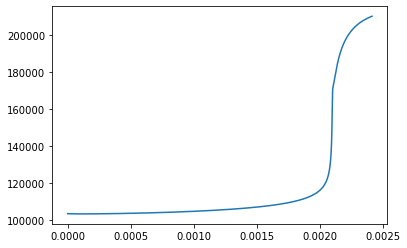

In [88]:
   
%matplotlib inline
N=-500
plt.plot(times[:N], P[:N])

In [36]:
gas.species()[4]

<Species butane(1)>

In [54]:
# set initial conditions
gas.TPX = 1077, ct.one_atm * 10, 'Ar: 0.7821, butane(1): 0.00962, O2(2): 0.2083'

In [55]:
end_time = 1.0  # time in seconds


# Create non-interacting ``Reservoir`` on other side of ``Wall``
env = ct.Reservoir(ct.Solution('air.xml'))

reactor = ct.IdealGasReactor(gas)

# Rapid compression machine modeled by constant UV
wall = ct.Wall(reactor, env, A=1.0, velocity=0)


reactor_net = ct.ReactorNet([reactor])

In [56]:
# Initial mol fractions from Table 2 of https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016


In [57]:

times = [0]
T = [reactor.T]
P = [reactor.thermo.P]
X = [reactor.thermo.X]  # mol fractions
while reactor_net.time < end_time:
    reactor_net.step()
    
    times.append(reactor_net.time)
    T.append(reactor.T)
    P.append(reactor.thermo.P)
    X.append(reactor.thermo.X)

In [58]:
times

[0,
 2.3969275846149217e-14,
 5.0357416428444915e-11,
 1.9373220244181203e-10,
 3.371069884551791e-10,
 4.804817744685462e-10,
 7.158933887147998e-10,
 1.2011547784602785e-09,
 1.6864161682057573e-09,
 2.171677557951236e-09,
 2.9468200705957604e-09,
 3.7219625832402846e-09,
 4.497105095884809e-09,
 5.2722476085293334e-09,
 6.568704710421971e-09,
 7.86516181231461e-09,
 9.161618914207248e-09,
 1.0458076016099886e-08,
 1.1754533117992523e-08,
 1.3050990219885161e-08,
 1.4347447321777799e-08,
 1.564390442367044e-08,
 1.7731895030195572e-08,
 1.9819885636720706e-08,
 2.190787624324584e-08,
 2.3995866849770974e-08,
 2.7354463274277603e-08,
 3.071305969878423e-08,
 3.407165612329086e-08,
 3.743025254779749e-08,
 4.078884897230412e-08,
 4.414744539681075e-08,
 4.7506041821317376e-08,
 5.0864638245824006e-08,
 5.4223234670330635e-08,
 5.7581831094837265e-08,
 6.09404275193439e-08,
 6.429902394385052e-08,
 6.765762036835715e-08,
 7.310911612919519e-08,
 7.856061189003323e-08,
 8.401210765087126

In [59]:
X_O2 = [x[5] for x in X]

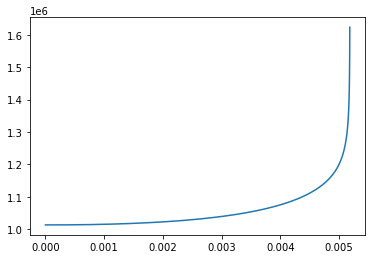

In [71]:
%matplotlib inline
N=2000
plt.plot(times[:N], P[:N])


In [5]:
gas.reactions()

[<ElementaryReaction: H(14) + O2(2) <=> O(5) + OH(15)>,
 <ElementaryReaction: H2(13) + O(5) <=> H(14) + OH(15)>,
 <ElementaryReaction: H2(13) + O(5) <=> H(14) + OH(15)>,
 <ElementaryReaction: H2(13) + OH(15) <=> H(14) + H2O(8)>,
 <ElementaryReaction: 2 OH(15) <=> H2O(8) + O(5)>,
 <ThreeBodyReaction: H2(13) + M <=> 2 H(14) + M>,
 <ElementaryReaction: Ar + H2(13) <=> Ar + 2 H(14)>,
 <ElementaryReaction: H2(13) + He <=> 2 H(14) + He>,
 <ThreeBodyReaction: 2 O(5) + M <=> O2(2) + M>,
 <ElementaryReaction: Ar + 2 O(5) <=> Ar + O2(2)>,
 <ElementaryReaction: He + 2 O(5) <=> He + O2(2)>,
 <ThreeBodyReaction: H(14) + O(5) + M <=> OH(15) + M>,
 <ThreeBodyReaction: H2O(8) + M <=> H(14) + OH(15) + M>,
 <ElementaryReaction: 2 H2O(8) <=> H(14) + H2O(8) + OH(15)>,
 <FalloffReaction: H(14) + O2(2) (+M) <=> HO2(16) (+M)>,
 <ElementaryReaction: H(14) + HO2(16) <=> H2(13) + O2(2)>,
 <ElementaryReaction: H(14) + HO2(16) <=> 2 OH(15)>,
 <ElementaryReaction: HO2(16) + O(5) <=> O2(2) + OH(15)>,
 <ElementaryRe